In this part we take a psychiatric diagnosis dataset from the University of Science and Technology of China- cdbd. This dataset consists of scores from 0 to 1 for all the study participants without disclosing their identity. It has more than 185k datapoints



First we begin by loading the dataset and splitting it into train and test dataset. We apply minmax normalisation on our dataset to aid the training. For the predictions and training we use the self-organising maps  Though it is an unsupervised technique but like most of the artificial neural networks, it operates in two modes training and mapping. It produces a low dimensional mapping of a higher dimensional data. The algorithm provides a score between 0 to 1 for every datapoint.


In [ ]:
!wget https://base.ustc.edu.cn/data/cdbd/a0910/train.csv

--2024-07-01 10:51:48--  https://base.ustc.edu.cn/data/cdbd/a0910/train.csv
Resolving base.ustc.edu.cn (base.ustc.edu.cn)... 218.104.71.173, 2001:da8:d800:642::248
Connecting to base.ustc.edu.cn (base.ustc.edu.cn)|218.104.71.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2329161 (2.2M) [application/octet-stream]
Saving to: ‘train.csv’

train.csv           100%[===================>]   2.22M   686KB/s    in 3.3s    

2024-07-01 10:51:52 (686 KB/s) - ‘train.csv’ saved [2329161/2329161]



In [ ]:
import pandas as pd
df = pd.read_csv('/content/train.csv')
df.head()

,user_id,item_id,score
0,1615,12977,1
1,782,13124,0
2,1084,16475,0
3,593,8690,0
4,127,14225,1


In [ ]:
df.shape

(186049, 3)

In [ ]:
import numpy as np
from numpy.ma.core import ceil
from scipy.spatial import distance #distance calculation
from sklearn.preprocessing import MinMaxScaler #normalisation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score #scoring
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib import animation, colors

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(df.iloc[:,:2].values, df.iloc[:,2].values, test_size=0.2, random_state=42)
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape) # check the shapes

(148839, 2) (148839,) (37210, 2) (37210,)


In [ ]:
def minmax_scaler(data):
  scaler = MinMaxScaler()
  scaled = scaler.fit_transform(data)
  return scaled

# Euclidean distance
def e_distance(x,y):
  return distance.euclidean(x,y)

# Manhattan distance
def m_distance(x,y):
  return distance.cityblock(x,y)

# Best Matching Unit search
def winning_neuron(data, t, som, num_rows, num_cols):
  winner = [0,0]
  shortest_distance = np.sqrt(data.shape[1]) # initialise with max distance
  input_data = data[t]
  for row in range(num_rows):
    for col in range(num_cols):
      distance = e_distance(som[row][col], data[t])
      if distance < shortest_distance:
        shortest_distance = distance
        winner = [row,col]
  return winner

# Learning rate and neighbourhood range calculation
def decay(step, max_steps,max_learning_rate,max_m_dsitance):
  coefficient = 1.0 - (np.float64(step)/max_steps)
  learning_rate = coefficient*max_learning_rate
  neighbourhood_range = ceil(coefficient * max_m_dsitance)
  return learning_rate, neighbourhood_range

In [ ]:
# hyperparameters
num_rows = 10
num_cols = 10
max_m_dsitance = 4
max_learning_rate = 0.5
max_steps = int(7.5*10e3)

In [ ]:
train_x_norm = minmax_scaler(train_x) # normalisation

# initialising self-organising map
num_dims = train_x_norm.shape[1] # numnber of dimensions in the input data
np.random.seed(40)
som = np.random.random_sample(size=(num_rows, num_cols, num_dims)) # map construction

# start training iterations
for step in range(max_steps):
  if (step+1) % 1000 == 0:
    print("Iteration: ", step+1) # print out the current iteration for every 1k
  learning_rate, neighbourhood_range = decay(step, max_steps,max_learning_rate,max_m_dsitance)

  t = np.random.randint(0,high=train_x_norm.shape[0]) # random index of traing data
  winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
  for row in range(num_rows):
    for col in range(num_cols):
      if m_distance([row,col],winner) <= neighbourhood_range:
        som[row][col] += learning_rate*(train_x_norm[t]-som[row][col]) #update neighbour's weight

print("SOM training completed")

Iteration:  1000
Iteration:  2000
Iteration:  3000
Iteration:  4000
Iteration:  5000
Iteration:  6000
Iteration:  7000
Iteration:  8000
Iteration:  9000
Iteration:  10000
Iteration:  11000
Iteration:  12000
Iteration:  13000
Iteration:  14000
Iteration:  15000
Iteration:  16000
Iteration:  17000
Iteration:  18000
Iteration:  19000
Iteration:  20000
Iteration:  21000
Iteration:  22000
Iteration:  23000
Iteration:  24000
Iteration:  25000
Iteration:  26000
Iteration:  27000
Iteration:  28000
Iteration:  29000
Iteration:  30000
Iteration:  31000
Iteration:  32000
Iteration:  33000
Iteration:  34000
Iteration:  35000
Iteration:  36000
Iteration:  37000
Iteration:  38000
Iteration:  39000
Iteration:  40000
Iteration:  41000
Iteration:  42000
Iteration:  43000
Iteration:  44000
Iteration:  45000
Iteration:  46000
Iteration:  47000
Iteration:  48000
Iteration:  49000
Iteration:  50000
Iteration:  51000
Iteration:  52000
Iteration:  53000
Iteration:  54000
Iteration:  55000
Iteration:  56000
I

In [ ]:
label_data = train_y
map = np.empty(shape=(num_rows, num_cols), dtype=object)

for row in range(num_rows):
  for col in range(num_cols):
    map[row][col] = [] # empty list to store the label

for t in range(train_x_norm.shape[0]):
  if (t+1) % 1000 == 0:
    print("sample data: ", t+1)
  winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
  map[winner[0]][winner[1]].append(label_data[t]) # label of winning neuron

sample data:  1000
sample data:  2000
sample data:  3000
sample data:  4000
sample data:  5000
sample data:  6000
sample data:  7000
sample data:  8000
sample data:  9000
sample data:  10000
sample data:  11000
sample data:  12000
sample data:  13000
sample data:  14000
sample data:  15000
sample data:  16000
sample data:  17000
sample data:  18000
sample data:  19000
sample data:  20000
sample data:  21000
sample data:  22000
sample data:  23000
sample data:  24000
sample data:  25000
sample data:  26000
sample data:  27000
sample data:  28000
sample data:  29000
sample data:  30000
sample data:  31000
sample data:  32000
sample data:  33000
sample data:  34000
sample data:  35000
sample data:  36000
sample data:  37000
sample data:  38000
sample data:  39000
sample data:  40000
sample data:  41000
sample data:  42000
sample data:  43000
sample data:  44000
sample data:  45000
sample data:  46000
sample data:  47000
sample data:  48000
sample data:  49000
sample data:  50000
sample da

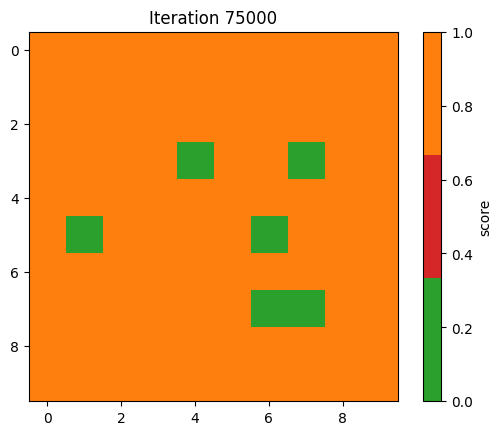

In [ ]:
label_map = np.zeros(shape=(num_rows, num_cols),dtype=np.int64)
for row in range(num_rows):
  for col in range(num_cols):
    label_list = map[row][col]
    if len(label_list)==0:
      label = 2
    else:
      label = max(label_list, key=label_list.count)
    label_map[row][col] = label

title = ('Iteration ' + str(max_steps))
cmap = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange'])
plt.imshow(label_map, cmap=cmap)
cbar  = plt.colorbar()
cbar.set_label('score')

plt.title(title)
plt.show()